# 8 Dimensionality Reduction

## The curse of Dimensionality

Here's a fun fact: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be 0.66. If you picked two points in a 1,000,000 dimensional hypercube, that distance would be about 408.25!

This example shows that high-dimension datasets can be very sparse; most training instances will likely be far away from each other. 

This also means that any new instance will be far away from any training instance, making predictions much less reliable than in lower dimensions. In short, the more dimensions the training set has, the more likely it is to overfit.

## Main approaches for dimensionality reduction

### Projection

In most real-world problems, training instances are *not* spread out uniformlyy across all dimensions. Many features are almost constant, while others are highly correlated. As a result, many instances lie within a much lower-dimensional subspace of the high-dimensional space.

Book shows example of 3D dataset that can be efficiently projected on 2D plane.

Counter example pg 217: Swiss roll dataset, projecting onto a plane would squash different layers of the swiss roll together.

### Manifold Learning

A *d*-dimensional manifold is part of an *n*-dimensional space (*d<N*) that locally resembles a *d*-dimensional hyperplane. In the case of the swiss roll, d=2 and n=3; it locally resembles a 2D plane but it is rolled in the thirds dimension

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called **manifold learning**. It relies on the *manifold assumption* (or manifold hypothesis) which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

The manifold assumption is often accompanies by another implicit assumption: that the task at hand (e.g. classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. Figure 8-6 on page 219 exemplifies this.

In short, reducing the dimensionality of your training set before training a model will usually speed up training, but it may not alwasy lead to a better or simpler solution; it all depends on the dataset.

## PCA

References:

[PCA deep dive](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/)

[Explained Variance Ratio](https://ro-che.info/articles/2017-12-11-pca-explained-variance)

*Principal component analysis* is by far the most popular dimensionality reduction algorithm used. First it identifies the hyperplane lying closest to the data, then projects the data onto it.

#### Preserving the variance

But how to choose the correct hyperplane? Choosing the axis that preserves the maximum amount minimises the amount of loss while projecting. (example fig 8-7 pg 220)

#### Principal components

PCA finds the axis that preserves the largest amount of variance in the training set. It also finds the a second axis (orthogonal to the first) that accounts for the largest amount of remaining variance. 

For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on th same axis, the direction of the unit vectors returned by PCA is not stable; if the training set is perturbed slightly and PCA ran again, the unit vectors may point in the opposite direction. However they will generally lie on the same axes.

How to find the principal components of a training set? Use a matrix factorization technique called *Singular Value Decomposition* (**SVD**), that can decompose the training set matrix $\textbf{X}$ into the matrix multiplication of three matrices $\textbf{U}\Sigma\textbf{V}^{\intercal}$, where $\textbf{V}$ contains the unit vectors that define all the principal components

In [26]:
import sys
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

3D dataset used

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X[:5,:]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

We can use numpy's *svd()* function to obtain principal components

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
c1

array([0.93636116, 0.29854881, 0.18465208])

Note: PCA assumes that the dataset is centered around the origin. Sklearn's PCA classes takes care of centering the data for you, but if you implement it yourself, don't forget to center the data

#### Projecting down to *d* dimensions
Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to *d* dimensions by projecting it onto the hyperplane defined by the first *d* principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$, as follows

$$ X_{d-proj} = XW_d $$

The following code projects the training set onto the plane defined by the first two principal components

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D[:5, :]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [7]:
X2D_using_svd = X2D

Below is the original 3D dataset

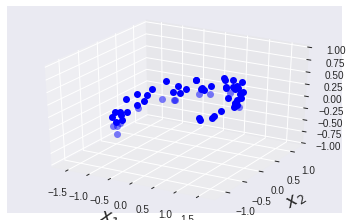

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

X3D_above = X[X[:, 2] > X3D_inv_using_svd[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv_using_svd[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

And when projected onto a 2D hyperplane, note that the black arrows indicate the principal components

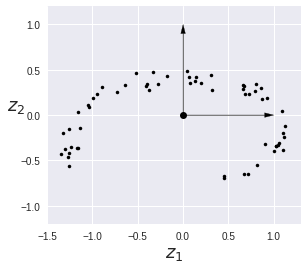

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

### Using Scikit-Learn
Scikit-learn also uses SVD to implement PCA. The attribute components_ holds the transpose of $W_d$

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [11]:
pca.components_.T

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

## Explained Variance Ratio
As we want to maximise the amount of variance each principal component explains, we can use the attribute *explained_variance_ratio_*

In [12]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In this case, the first component contributes to 84% of the variance while the second contributes to 14%. This leaves just over 1% of the variance explained by a third PC, so it is reasonable to assume it carries little information

### Choosing the right number of dimensions

Instead of arbitrarily choosing the number of dimensions to reduce to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g. 95%)

The following code performs PCA without reducing dimensionality, then computes the minum number of dimensions required to preserve 95% of the training set's variance (MNIST dataset)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(d)

154


Better than that, we can instead specify this threshold by setting the number of components as a float between 0 and 1

In [15]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

Yet another option is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve, where the explained variance stops growing fast

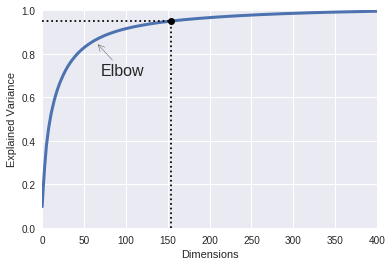

In [16]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In this case, reducing dimensionality to about 100 is a good threshold

### PCA for Compression

After reducing a dataset with PCA, it occupies much less space. For example, applying PCA to MNIST to preserve 95% of explained variance (as above) gives about 154 dimensions, which is much less than the original 784 features. So while most of the variance is preserved, the dataset is less than 20% of it's original size. This is a reasonable compression ratio and can help speed up training (for example of a SVC).

It is also possible to decompress the reduced dataset back to it's original 784 dimensions by using the inverse_transform method.

The reconstructed image will have some error but it will likely be close to the data. The mean squared distance between the original data and the reconstructed data is called the *reconstruction error*.

The equation of the inverse transformation is 

$$ \textbf{X}_{\text{recovered}} = \textbf{X}_{d-\text{proj}}\textbf{W}^{\intercal}_d $$

### Randomized PCA

By setting the svd_solver hyperparameter of PCA to "randomized", Scikit-learn uses a stochastic algorithm called *Randomized PCA* to calculate an approximation of the first *d* first principal components.

It's computational complexity is $O(m\times d^2) + O(d^3)$ instead of $O(m\times n^2) + O(n^3)$ for the full SVD approach. (m = # of training instances, n = # of features)

In [20]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for algorithms to run. 

For large datasets (and online training), we can use *Incremental PCA*, which allow us to split the training set into mini-batches and feed it to the algorithm one batch at a time.

In [21]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch) # Note the use of partial_fit
    
X_reduced = inc_pca.transform(X_train)

See book pg 226 for snippet on Numpy's memmap

### Kernel PCA

Recall that in chapter 5 we discussed the kernel trick: "Using a kernel, means that instead of applying a transformation to our dataset (for example $\phi$), which might be computationally expensive, we can insted use the result directly. "

The same trick can be applied to PCA, making it possible to perform complex nonlinear projections - [Kernel PCA](https://homl.info/33). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold

The plot below shows the Swiss rol reducted to two dimensions using a linear kernel (equivalent to using the PCA class), an RBF kernel and a sigmoid kernel

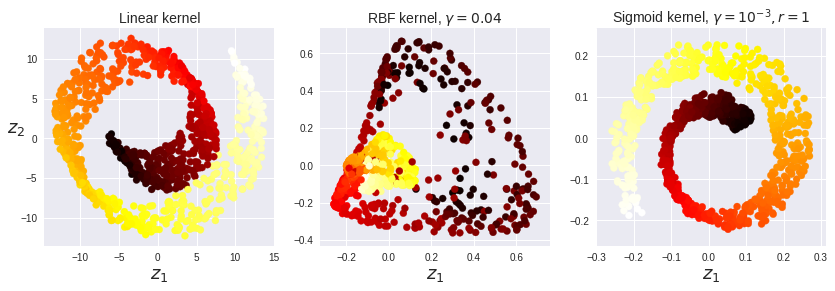

In [32]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

plt.figure(figsize=(14, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#### Selecting a Kernel and tuning hyperparameters
As kPCA is unsupervised, there's no obvious performance measure to help selecting the best kernel and hyperparameter values.

With that said, dimensionality reduction is usually a preparatory step in supervised learning (e.g. classification), so we can use grid search to select the kernel and hyperparameters that lead to the best performance on that task

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])
param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [35]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

Another approach is to select the kernel and hyperparameters that yield the lowest reconstruction error. pg 228 explains this process with code snippets and a great diagram

### Locally Linear Embedding (LLE)

[LLE](https://homl.info/lle) is another powerful *nonlinear dimensionality reduction (NDLR)* technique. It is a manifold learning Technique that does not rely on projections, unlike the previous algorithms. It works as follows

First, measure how each training instances linearly relates to its closest neighbours (c.n.) and then looking for a low-dimensional representaion of the training set where these local relationships are best preserved.

This approach makes it particularly good at unrolling twisted manifolds, especially when there isn't much noise.

In [40]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

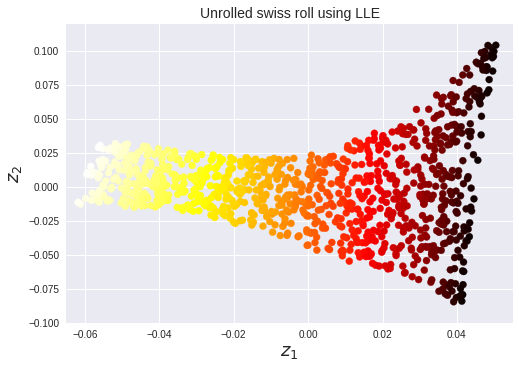

In [41]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

The swiss roll is completely unrolled and the distances between instances are locally well preserved, however they are not preserved at a larger scale: the left part is squished while the right part is stretched.

The inner workings of LLE involve constraint programming and as it is outside of the scope of these studies it will be omitted here. More info on book pg 231

One of the main drawbacks of scikit-learn's implementation of LLE is it's computational complexity:
* $O(m\log{m} \text{ } n \log{k})$ for finding k-neighbors
* $O(mnk^3)$ for optimizing the weights
* $O(dm^2)$ for constructing the low-dimensional representations

The $m^2$ in the last term scales poorly with large datasets